<img src="https://www.th-ab.de/typo3conf/ext/th_ab/Resources/Public/assets/logo-th-ab.svg" alt="TH-AB Logo" width="200"/>

Prof. Dr. Möckel, Prof. Dr. Radke, Katharina Kuhnert

Maschinelles Lernen Schwerpunkt Data Science<br>
SoSe 2024

# Vorlesung 6: Lineare und nichtlineare Klassifikation mit Neuronalen Netzen in PyTorch

### Bibliotheken importieren und PyTorch Umgebung prüfen

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

# PyTorch
try:
    import torch
    import torchvision
    import torchmetrics
except:
    !pip install torch
    !pip install torchvision
    !pip install torchmetrics
    import torch
    import torchvision
    import torchmetrics

from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# PyTorch Version überprüfen
if (torch.__version__ < "2.0.0"):
    raise Exception("Wrong PyTorch version")
else:
    print("PyTorch Version:", torch.__version__)

PyTorch Version: 2.0.0+cpu


### Datasets aus MNIST laden und für maschinelles Lernen in Teildatensätze aufteilen 
* Training dataset
* Non-training dataset (Validierung und Test)

In [3]:
# Dataset für Training
ds_train = datasets.MNIST(
    root="data", # Zielpfad für Datendownload
    train=True, # Trainingsdaten laden
    download=True,
    transform=ToTensor(), # Transformiere Features (Bilddaten) zu Tensoren
    target_transform=None # Keine Transformierung für Labels (Targets)
)

# Dataset für Validierung und Test
ds_non_train = datasets.MNIST(
    root="data",
    train=False, # Keine Trainingsdaten laden
    download=True,
    transform=ToTensor()
)

# Splitting des non-train Dataset in:
# 50% für Validierung (Modellvalidierung)
# 50% für Tests
total_count = len(ds_non_train)
valid_count = int(0.5 * total_count) 
test_count = int(0.5 * total_count)

# Splitte non-Train Dataset
ds_valid, ds_test = torch.utils.data.random_split(ds_non_train, (valid_count, test_count))

Beispiel eines Datenpunktes bestehend aus einem Bild und einem Label:

In [4]:
# Dataset enthält Features und Labels
image, label = ds_train[2]

print("[color_channels, height, width] ->", image.shape)
print("Training Samples:", len(ds_train))

# Konvertiere image auf 2 dim mit squeeze()
plt.imshow(image.squeeze(), cmap="gray")
plt.title(label)
plt.show()

[color_channels, height, width] -> torch.Size([1, 28, 28])
Training Samples: 60000


: 

Da das Dataset für die Klassifikation von Ziffern gedacht ist entsprechen die Labels die Bezeichnungen der jeweiligen Ziffern. Die Klassen des Datasets lassen sich über das Attribut `.classes` ermitteln:

In [ ]:
class_names = ds_train.classes
class_names

Eine kleine Übersicht über enthaltene Samples:

In [ ]:
# Setze den Seed für die Generierung von Zufallszahlen
torch.manual_seed(42)

# Plotte eine Matrix aus zufällig ausgewählten Datenpunkten (Features und Labels) des Datasets
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(ds_train), size=[1]).item()
    img, label = ds_train[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

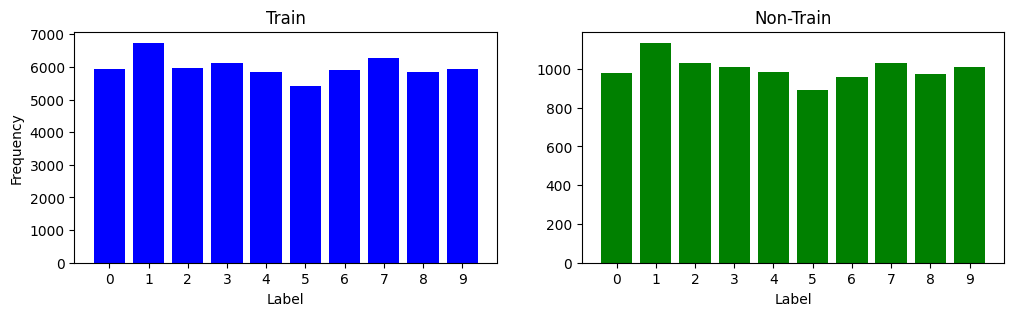

In [7]:
# Verteilung der Targets auf die einzelnen Klassen
train_prop = ds_train.targets.bincount()
val_prop = ds_non_train.targets.bincount()


# Visualisierung 
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
for ax, prop, title, col in zip(axes, [train_prop, val_prop], ['Train', 'Non-Train'], 'bg'):
    class_target = range(0, 10)
    ax.bar(class_target, prop, color=col)
    ax.set_title(title)
    ax.set_xticks(class_target)
    ax.set_xlabel("Label")

axes[0].set_ylabel("Frequency")
plt.show()

### Initiierung der DataLoader

Das schrittweise Laden der Daten aus dem Datensatz in Abschnitten (batches) wird durch Datenloader realisiert. 

In [8]:
from torch.utils.data import DataLoader

# Nutze eine Batch-größe von 32 "Datenpunkten" pro Batch
BATCH_SIZE = 32

# Die DataLoader Klasse ermöglicht die Iteration durch die
# Datenpunkte eines Datasets
train_dataloader = DataLoader(ds_train, 
    batch_size=BATCH_SIZE,
    # Zufällige Auswahl für jedes Batch
    shuffle=True
)

# DataLoader für Validierung
valid_dataloader = DataLoader(ds_valid, batch_size=BATCH_SIZE, shuffle=True) 

# DataLoader für Tests
test_dataloader = DataLoader(ds_test , batch_size=BATCH_SIZE, shuffle=False)

# Ausgabe der Dataloader
print("Größe train_dataloader:", len(train_dataloader), "Batches zu je", BATCH_SIZE, "Datenpunkten")
print("Größe valid_dataloader:", len(valid_dataloader), "Batches zu je", BATCH_SIZE, "Datenpunkten")
print("Größe test_dataloader:", len(test_dataloader), "Batches zu je", BATCH_SIZE, "Datenpunkten")

Größe train_dataloader: 1875 Batches zu je 32 Datenpunkten
Größe valid_dataloader: 157 Batches zu je 32 Datenpunkten
Größe test_dataloader: 157 Batches zu je 32 Datenpunkten


Der Zugriff auf die Daten über den DataLoader erfolgt per Iterator:

In [9]:
# Iterator erzeugen
train_iter = iter(train_dataloader)

# Ein Batch aus Features und Labels über `next()` erhalten
# Größe entspricht der BATCH_SIZE!
train_features_batch, train_labels_batch = next(train_iter)

# Shapes ausgeben
print("[num_elements, color_channels, height, width] ->", train_features_batch.shape)
print("[num_labels] ->", train_labels_batch.shape)

[num_elements, color_channels, height, width] -> torch.Size([32, 1, 28, 28])
[num_labels] -> torch.Size([32])


Der Zugriff auf Features und Labels ist über den `[]` Operator des Objekts möglich:

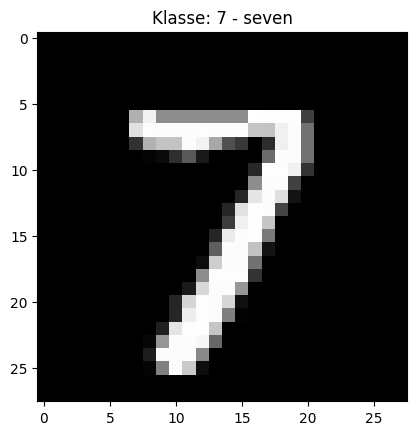

In [10]:
# Zeige ein Feature an
img, label = train_features_batch[10], train_labels_batch[10]
plt.imshow(img.squeeze(), cmap="gray")
plt.title("Klasse: " + class_names[label])
plt.show()

## Aufbau von Modellen in PyTorch

Der Aufbau von Modellen in PyTorch erfolgt in zwei Schritten

(1) zunächst wird die *Topologie* des Modells (Anordnung seiner Bestandteile) als __Graph__ in einer __abstrakten Klasse__ realisiert. 

(2) in einem zweiten Schritt wird ein Modell als __Objekt__ dieser Klasse angelegt, wobei wichtige Strukturparameter des Modells (Hyperparameter) gesetzt werden. 


### Beispiel: __Lineares__ Modell zur Klassifikation von Bildern

Das im folgenden beschriebene lineare Modell ist mnoch kein neuronales Netz im eigentlichen Sinne, da ihm eine wichtige Eigenschaft der Neuronen, nämlich die nichtlineare Aktivierungsfunktion, fehlt. Dennoch lassen sich alle wesentlichen Schritte des maschinellen Lernens bereits an diesem Modell aufzeigen. 

Ein lineares Modell könnte auch durch eine einzelne Matrix von geeigneter Größe realisiert werden, da mehrere, aufeinander folgende Matritzen immer ausmultipliziert werden können. Eine Schichtstruktur mit mehreren Layer bringt in diesem Fall also keinen Mehrwert. Erst bei Hinzunahme nichtlinearer Aktivierungsfunktionen ist dies der Fall (s.u.)

*En passant* wird das abstrakte Konzept eines Graphen verdeutlicht. Dieser beschreibt die Operationen, welche später mit den Daten durchgeführt werden, ohne sie sofort auszuführen. Erst durch die Anwendung des Graphen auf konkrete Daten werden Rechenoperationen ausgeführt. 

Zunächst müssen die Input-Daten restrukturiert werden. Jeder Datenpunkt aus dem verwendeten Datensatz wird als Zeile von Einzelwerten geschrieben. Hierzu kann die Funktion `nn.Flatten()` nützlich sein: sie transformiert Features (n x m Pixel) in eine Sequenz aus Pixeln (d.h. in einen Zeilenvektor). Der Begriff flatten ist motiviert von der Umformung einer Matrix zu einem Zeilenvektor mit gleich vielen Elementen. Eine äquivalente Lösung wäre mit dem Befehl reshape aus der Bibliothek numpy möglich. Folgendes Beispiel illustriert diese Funktion:

In [11]:
# Erstes Feature (hier: Bild) aus dem Trainingsbatch
X = train_features_batch[0]
print()

# Erstellung eines minimalen Graphen, der nur eine Umformung von Daten mit nn.Flatten durchführt
Flatten_Graph = nn.Flatten()

# Anwendung des Graphen auf die Daten bewirk Umformung der Bilddaten in einen Zeilenvektor
X_t = Flatten_Graph(X)

print("Vor der Transformation [color_channels, height, width]:", X.shape)
print("Nach der Transformation [color_channels, height*width]:", X_t.shape)

# Alternative in numpy (nicht empfohlen): 
import numpy as np
# Direkte Umformung der Daten
X_t2 = np.reshape(X, (1,X.numel()))
print("Nach der Transformation mit np.reshape [color_channels, height*width]:", X_t2.shape)

# Vergleich beider Ansätze:
print("Differenz der beiden Ansätze zum Flatten: ", sum(sum(X_t-X_t2)))


Vor der Transformation [color_channels, height, width]: torch.Size([1, 28, 28])
Nach der Transformation [color_channels, height*width]: torch.Size([1, 784])
Nach der Transformation mit np.reshape [color_channels, height*width]: torch.Size([1, 784])
Differenz der beiden Ansätze zum Flatten:  tensor(0.)


### Objektorientierte Erstellung eines Graphen:

Die Definition eines Modells in PyTorch geschieht durch Definition einer neuen Klasse (mit dem Namen des Modells), die üblicherweise von der Basisklasse `nn.Module` abgeleitet wird. Dadurch übernimmt sie alle Funktionen, die in 'nn.Module' vordefiniert sind. 

Im Standard-Konstruktor der neuen Klasse wird der Graph des betrachteten Modells realisiert. Die Anwendung des Graphen auf die Daten wird in einer Forward-Funktion definiert, die in der neuen Klasse geeignet überschrieben werden sollte. In nn.Module besteht zudem die Funktion .call() als wrapper um die forward-Funktion, mit der ebenfalls die Anwendung des Graphen auf die Daten durchgeführt werden kann.

Es soll nun im Stil eines Neuronalen Netzes ein Graph als Sequenz der Operationen  

(1) Restrukturierung der Daten durch nn.Flatten

(2) Lineare Verknüpfung der Input-Daten mit den "Neuronen" einer hidden layer (ohne Aktivierungsfunktion; all-to-all)

(3) Lineare Verknüpfung der hidden layer mit einem Output (all-to-all) 

realisiert werden. Die Anzahl der Inputs, die Größe der hidden layer sowie die Zahl der Outputs seien durch Variablen flexibel. Zudem sollen durch 

(4) Anwendung der softmax-Funktion die Werte eines Vektors in Wahrscheinlichkeiten (also in normierte Werte zwischen 0 und 1) umgeformt werden. 

##### __Softmax-Funktion__
Die Softmax-Funktion $\sigma()$ ist offensichtlich stets positiv, nimmt Werte in [0,1] und ist normiert auf 1. Sie eignet sich daher zur Umrechnung von Komponenten ($z_i$) eine Vektors der Länge $K$ in Wahrscheinlichkeiten. 

$$ \sigma(\vec{z})_i = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}} $$



##### Aufbau des __Graphen__ innerhalb des Standardkonstruktors

In [12]:
# Definiere lineares Modell
class LinearModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        # Konstruktor der Basisklasse aufrufen
        super().__init__()

        # Graph eines linearen Modells als Sequenz: Reshape der Daten -> Neuronen der Hidden Layer (ohne Aktivierungsfunktion) -> Ergebnisklassen
        # in_ und out_ legt für jeden Einzelschritt fest, welches Datenformat verwendet werden muss
        
        self.layer_stack = nn.Sequential(
            # Schritt 1: Umwandeln in Vektor
            nn.Flatten(),
            # Schritt 2: Verknüpfung von Inputs und der Hidden Layer
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            # Schritt 3: Verknüpfung von Hidden Layer mit Output
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            # Schritt 4: Aktivierunsfunktion auf Output layer
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        # Die Vorwärtspropagation bedeutet die Ausführung der Schichten
        # nacheinander.
        return self.layer_stack(x)

##### Definition eines __konkreten Modells als Objekt__ der neu definierten Klasse LinearModel 

und Spezifikation der fehlenden Werte (Topologie und Hyperparameter) im Standardkonstruktor 

In [13]:
# Lade beliebiges Image aus Trainingsdataset zur Bestimmung der Datenformate
image, label = ds_train[0]
print(image.shape)

# Definition eines Objekt der Klasse LinearModel (=Modell), das zur Struktur der Daten im Datensatz passt:

model_0 = LinearModel(
    # Input ist Feature (Bild) mit n x m Pixeln Größe
    input_shape = image.shape[1]*image.shape[2],

    # Erzeuge 12 Neuronen im Hidden Layer
    hidden_units = 12,

    # Output-Layer des NN hat für jeden Klassenname ein Neuron
    output_shape = len(class_names)
)

# PyTorch kann unter anderem GPU oder CPU nutzen.
# Weise dem Modell die CPU zu.
model_0.to("cpu")

torch.Size([1, 28, 28])


LinearModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=12, bias=True)
    (2): Linear(in_features=12, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )
)

### Erweiterung zu einem Multi-Layer Perzeptron mit RELU-Aktivierungsfunktion 

Das Multilayer-Perzeptron ist ein vollvermaschtes Neuronales Netz, d.h. alle Neuronen einer Schicht sind mit allen Neuronen der vorherigen sowie der nachfolgenden Schicht verknüpft. 
Als Aktivierungsfunktion wird die (schwach) nichtlineare Funktion RELU eingesetzt. 

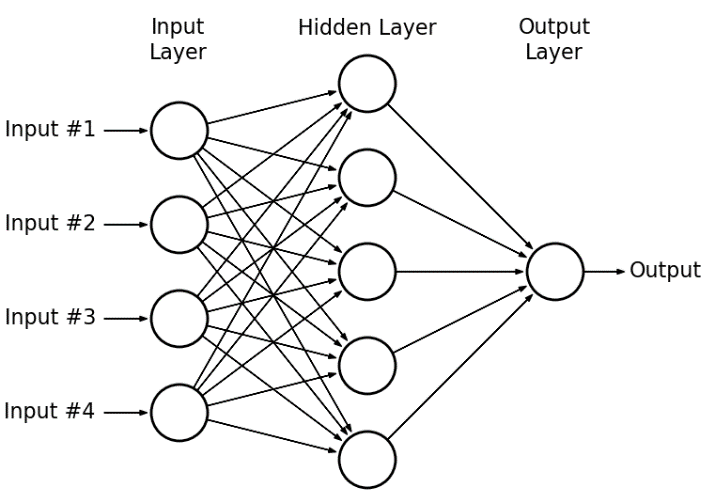

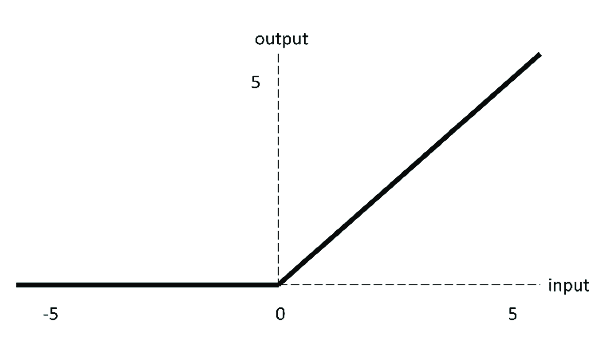

##### Definition einer __neuen Klasse MLP_RELU__ mit modifiziertem __Graph__ innerhalb des Standardkonstruktors

In [14]:
class MLP_RELU(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        # Konstruktor der Basisklasse aufrufen
        super().__init__()

        # Neuronales Netz konstruieren
        self.layer_stack = nn.Sequential(
            # Schritt 1: Umwandeln in Vektor
            nn.Flatten(),
            # Schritt 2: Verknüpfung von Inputs und der Hidden Layer
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            # Schritt 3: Rectified Linear Unit einfügen
            nn.ReLU(),
            # Schritt 4: Verknüpfung von Hidden Layer mit Output
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            # Schritt 5: Aktivierunsfunktion auf Output layer
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

##### Definition eines konkreten MLP-RELU Modells als Objekt:

durch Festlegung der topologiebezogenen Hyperparameter

In [15]:
# Erzeuge konkretes nicht-lineares Modell über Angabe der Parameter
model_1 = MLP_RELU(
    # Input ist Feature (Bild) mit n x m Pixeln Größe
    input_shape = image.shape[1]*image.shape[2],

    # Erzeuge 12 Neuronen im Hidden Layer
    hidden_units = 12,

    # Output-Layer des NN hat für jeden Klassenname ein Neuron
    output_shape = len(class_names)
)

# PyTorch kann unter anderem GPU oder CPU nutzen.
# Weise dem Modell die CPU zu.
model_1.to("cpu")


MLP_RELU(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=12, bias=True)
    (2): ReLU()
    (3): Linear(in_features=12, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)

## Training von Modellen in PyTorch

Zum Training ist das Modell in eine Optimierungsschleife einzubetten. Dazu benötigt man eine Vorschrift zur Ermittlung des Fehlers des Modells, welcher im Zuge der Optimierung minimiert werden soll.

### Auswahl einer geeigneten Fehler- (Loss) bzw. Kostenfunktion (Cost)

Für ein Klassifikationsproblem geeignet ist die sog. Kreuzentropie (cross entropy) zwischen dem Output des Modells $y$ sowie dem wahren Label (target)  $\hat y = S$

$$ L(y,\hat{y}) = -\sum_k^K \hat{y}^{(k)} \log(y^{(k)}) $$

(Bildnachweis: https://ieeexplore.ieee.org/document/8862886)


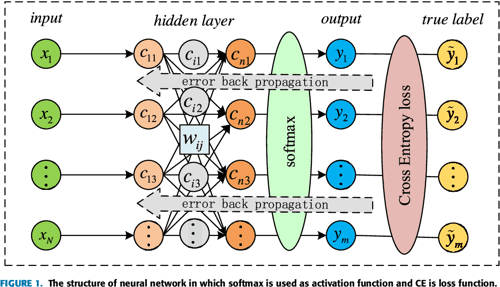

In [16]:
# Verwende Cross Entropy als Loss Funktion
loss_fn = nn.CrossEntropyLoss()

### Optimierundalgorithmus auswählen und dessen Hyperparameter setzen

Gewählt wird hier das Gradientenabstiegsverfahren als Stochastic Gradient Descent (SGD), das einen Hyperparameter, nämlich die Schrittweite für einen Schritt entlang des Gradienten (learning rate) hat. 

In [17]:
# Hyperparameter Lernrate
LEARN_RATE = 0.1

# Nutze Stochastic Gradient Descent als Optimierfunktion
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=LEARN_RATE)

### Durchführung des Trainings eines Modells mit Trainingsdaten

Training ist die Durchführung einer Optimierung der freien Parameter eines Modells mit dem Ziel, die Abweichung zwischen der Vorhersage eines Modells (Output) sowie den wahren Ergebnissen (Labels) auf Trainingsdaten zu minimieren.

Dazu werden die verfügbaren Trainingsdaten mehrfach durch den Optimierungsalgorithmus geleitet. Wie oft dies geschieht, beschreibt die Zahl der Epochen. Die äußere Struktur ist also eine Schleife über die Anzahl der Epochen. Üblicherweise wird entweder eine fest vorgegebene Zahl an Epochen durchlaufen oder ein Kriterium für die Größe des zulässigen Restfehlers festgelegt. 

Innerhalb einer Epoche werden nicht alle Trainingsdaten gleichzeitig eingesetzt, sondern nacheinander in kleinen Portionen, den sog. Batches. Die innere Struktur ist also eine Schleife über die Anzahl der Batches, die aus dem Trainingsdatensatz gebildet werden können.

##### Training des linearen Modells:

In [18]:
# Initiierung der trainierbaren Parameter durch Zufallszahlen
torch.manual_seed(42)

# Hyperparameter Zahl der Epochen
EPOCHS = 5

# Dokumentation des verbliebenen Fehlers in jeder Epoche (für Plotting)
t_loss = []

for epoch in range(EPOCHS):
    print("Epoch:", epoch, end="\n-------\n")

    train_loss = 0   # Anfangswert zu Beginn einer jeden Epoche

    # Laden der Trainingsdaten durch Durchzählen der Batches mit X: data (Bilder), y: targets/labels (Ziffern)
    for batch, (X, y) in enumerate(train_dataloader):

        # Initiierung des linearen Modell in den Trainingsmodus (kein Training! Nur Modus setzen.)
        model_0.train() 

        # NN 1. Forwärts-Propagation der Features (Bilddaten) durch das Modell bis zum Output ergibt Vorhersage (Prädiktion)
        y_pred = model_0(X)

        # NN 2. Berechne loss für die aktuelle Batch durch Vergleich der Prädiktion mit den Labels
        loss = loss_fn(y_pred, y)

        # Summation des Training loss über die aktuelle Epoche
        train_loss += loss

        # NN 3. Initiiere Optimizer Gradients auf 0
        optimizer.zero_grad()

        # NN 4. Initiiere Rückwärtspropagation des Fehlers
        loss.backward()

        # NN 5. Optimiere
        # Veränderung der Gewichte im Neuronalen Netz durch Zuweisung von Anteilen des Gesamtfehlers
        optimizer.step()

        # Ausgabe der bisher verarbeiteten Samples (Bild + Label)
        if batch % 400 == 0:
            print("Samples verarbeitet:", batch * len(X), "/", len(train_dataloader.dataset))

    # Ausgabe des durchschnittlichen Fehlers
    train_loss /= len(train_dataloader)

    # Speichere Trainingfehler
    t_loss.append(train_loss)

    print("Trainingsfehler: {:.5f}".format(train_loss))

Epoch: 0
-------
Samples verarbeitet: 0 / 60000
Samples verarbeitet: 12800 / 60000
Samples verarbeitet: 25600 / 60000
Samples verarbeitet: 38400 / 60000
Samples verarbeitet: 51200 / 60000
Trainingsfehler: 1.81010
Epoch: 1
-------
Samples verarbeitet: 0 / 60000
Samples verarbeitet: 12800 / 60000
Samples verarbeitet: 25600 / 60000
Samples verarbeitet: 38400 / 60000
Samples verarbeitet: 51200 / 60000
Trainingsfehler: 1.62868
Epoch: 2
-------
Samples verarbeitet: 0 / 60000
Samples verarbeitet: 12800 / 60000
Samples verarbeitet: 25600 / 60000
Samples verarbeitet: 38400 / 60000
Samples verarbeitet: 51200 / 60000
Trainingsfehler: 1.56240
Epoch: 3
-------
Samples verarbeitet: 0 / 60000
Samples verarbeitet: 12800 / 60000
Samples verarbeitet: 25600 / 60000
Samples verarbeitet: 38400 / 60000
Samples verarbeitet: 51200 / 60000
Trainingsfehler: 1.55266
Epoch: 4
-------
Samples verarbeitet: 0 / 60000
Samples verarbeitet: 12800 / 60000
Samples verarbeitet: 25600 / 60000
Samples verarbeitet: 38400 / 6

### Darstellung des Fehlers auf den Trainingsdaten

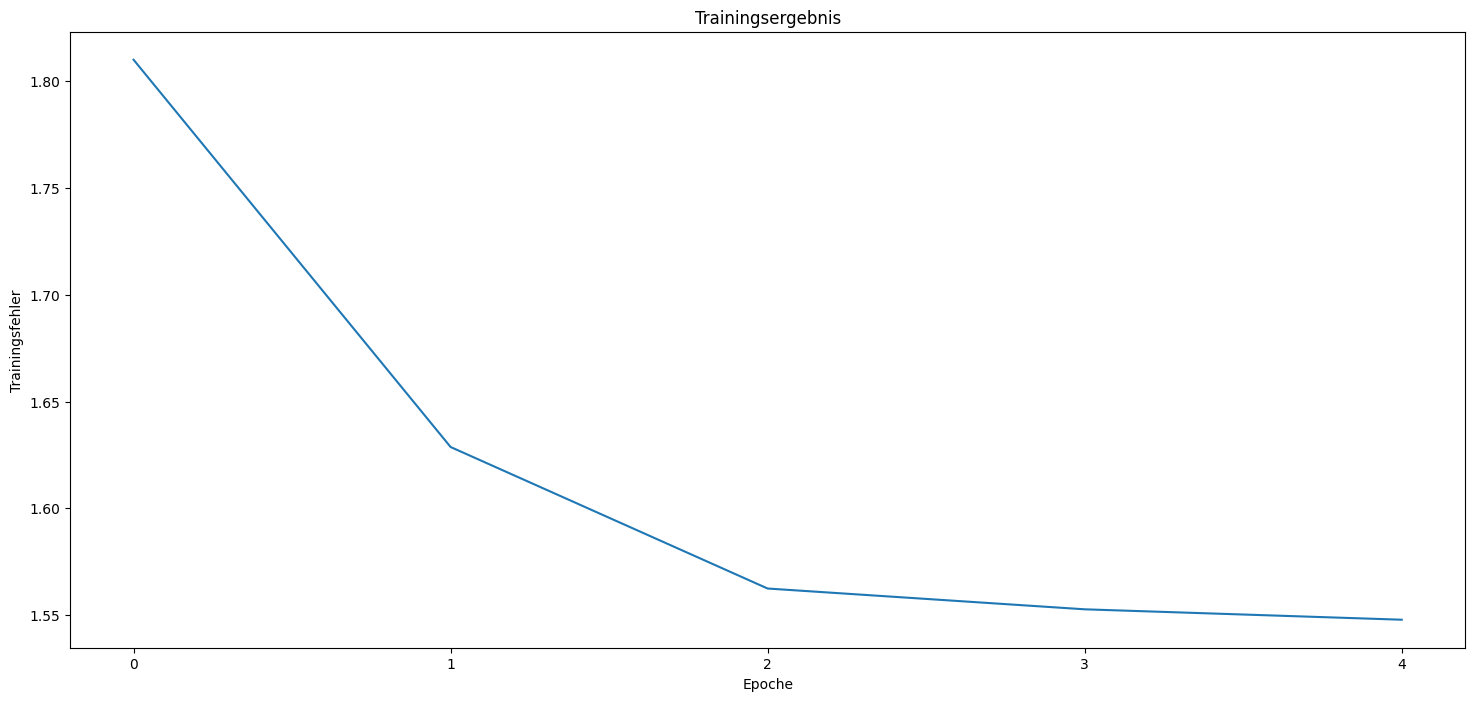

In [19]:
# Lambda um Liste aus Tensoren in Liste aus Float umzuwandeln
y_loss = lambda b : [x.tolist() for x in b]

# Lambda um y-Werte für Plot zu erzeugen
x_loss = lambda b : [ x for x in range(0, b)]

plt.figure(figsize=(18, 8))
plt.plot(x_loss(EPOCHS), y_loss(t_loss))
plt.xlabel("Epoche")
plt.ylabel("Trainingsfehler")
plt.title("Trainingsergebnis")
plt.xticks(x_loss(EPOCHS))
plt.show()

## Beurteilung des Trainingserfolgs mit Metriken (__Confusion matrix__)

Zur Beurteilung der Genauigkeit eines Maschinenlernverfahrens und zum Benchmarking unterschiedlicher Modelle bzw. (Optimierungs-)Algorithmen gegeneinander werden *Metriken* eingesetzt. 
Bei einem Klassifikationsproblem ist die Beurteilung der korrekten bzw. fehlerhaften Klassifikationen eine diskrete Frage und kann als *confusion matrix* dargestellt werden. Dabei werden in einer Matrix die wahren Label gegen die vorhergesagten Label aufgetragen. 

Dazu werden die Bilder des Testdatensatzes durch das Modell (vorwärts) propagiert und die Vorhersagen mit den Labels verglichen. 

In [20]:
y_test = []
y_pred = []

# Abschalten der Gradientenberechnung (nicht notwendig bei Evaluation)
with torch.no_grad():
    # Umschalten vom Training- in den Evaluationsmodus
    # Alternative: model_0.train(False) 
    model_0.eval()

    # loop for each data
    for X,y in test_dataloader:
        # STEP 1: forward pass
        output = model_0(X)
        # STEP 2: get predicted label
        _, pred_label = torch.max(output, dim=1)
        # STEP 3: append actual and predicted label
        y_test += y.numpy().tolist()
        y_pred += pred_label.numpy().tolist()

Die wahren targets (y_test) und die vorhergesagten Ziffern (y_pred) stimmen in diesem Beispiel fast immer überein:

In [21]:
print(y_test)
print(y_pred)

[5, 2, 0, 3, 3, 3, 8, 3, 1, 4, 0, 6, 1, 5, 7, 2, 1, 2, 9, 4, 7, 1, 3, 2, 1, 0, 3, 3, 6, 9, 6, 8, 5, 3, 7, 4, 3, 4, 3, 8, 5, 8, 5, 7, 1, 2, 3, 5, 9, 3, 6, 1, 9, 3, 1, 7, 8, 2, 0, 8, 7, 6, 1, 4, 3, 9, 9, 8, 1, 9, 8, 6, 0, 5, 5, 7, 5, 7, 0, 9, 9, 2, 4, 2, 4, 3, 0, 2, 7, 1, 1, 5, 8, 6, 3, 4, 1, 9, 3, 1, 6, 9, 8, 5, 5, 8, 7, 8, 7, 7, 0, 2, 9, 1, 6, 3, 2, 3, 7, 1, 3, 2, 2, 5, 7, 6, 6, 8, 9, 1, 0, 1, 9, 0, 6, 9, 3, 0, 0, 9, 1, 1, 3, 0, 7, 2, 5, 3, 6, 4, 7, 1, 9, 9, 1, 1, 1, 0, 6, 4, 7, 5, 7, 7, 0, 9, 1, 6, 7, 8, 1, 6, 1, 9, 5, 1, 3, 1, 8, 5, 6, 9, 5, 9, 5, 0, 7, 6, 1, 2, 6, 3, 5, 0, 2, 3, 6, 2, 7, 2, 3, 8, 8, 1, 1, 0, 6, 5, 4, 8, 1, 0, 4, 9, 5, 0, 7, 7, 4, 1, 4, 0, 4, 9, 2, 4, 6, 6, 3, 5, 4, 8, 1, 3, 7, 7, 2, 6, 1, 6, 9, 0, 9, 5, 1, 8, 4, 4, 9, 4, 8, 7, 3, 1, 3, 1, 6, 2, 7, 0, 4, 8, 2, 1, 3, 8, 0, 7, 0, 7, 0, 0, 2, 0, 7, 5, 5, 3, 6, 9, 1, 5, 6, 0, 5, 3, 8, 1, 8, 6, 0, 9, 0, 3, 7, 7, 0, 6, 6, 1, 3, 5, 7, 5, 3, 0, 7, 9, 6, 2, 4, 4, 8, 3, 3, 7, 9, 6, 7, 7, 7, 0, 4, 2, 5, 5, 6, 9, 2, 4, 8, 1, 7, 

Die confusion matrix lässt sich leicht als heatmap darstellen:

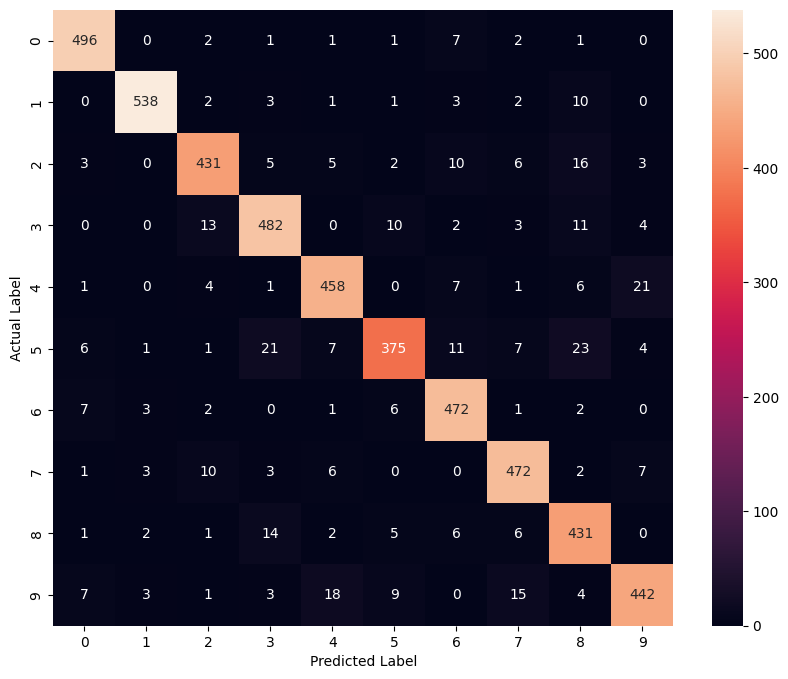

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.subplots(figsize=(10, 8))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("Actual Label")
plt.show()

Aus den Einträgen der Confusion Matrix lassen sich nun abgeleitete Metriken definieren. Dazu kann für jede Klasse die Beurteilung auf eine binäre Klassifikation (z.B. "ist 0" und "ist nicht 0") reduziert werden

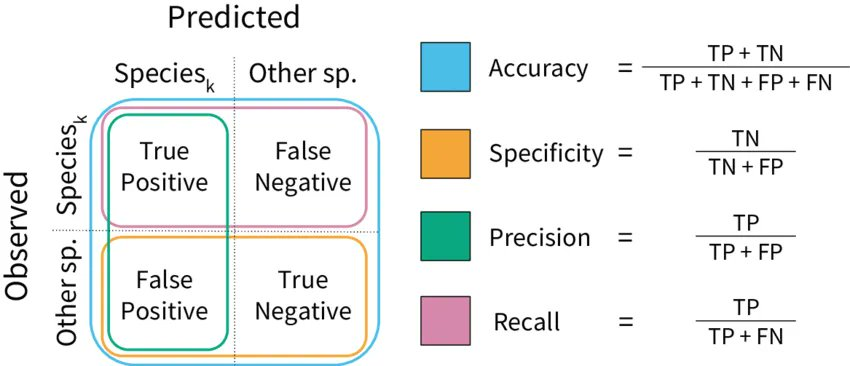

#### __Accuracy__:
- Verhältnis der korrekt ermittelten Ergebnisse zu allen Daten
- Problematisch im Falle von großem bias (ungleichen Verteilungen über die Klassen)

#### __Precision__:
- Beschreibt Güte des Klassifikators bei der Vermeidung von falsch positiven Ergebnissen

#### __Recall__:
- Beschreibt Güte des Klassifikators bei der Detektion aller tatsächlich positiven Ergebnisse

#### __Specificity__:
- Beschreibt Güte des Klassifikators bei der Identifikation von tatsächlich negativen Ergebnissen

#### __F1 score__:

$$ F_1 = 2 * \frac{precision * recall}{precision + recall} $$
- Harmonisches Mittel von precision und recall
- Balance zwischen precision and recall 



In [23]:
from sklearn.metrics import classification_report, auc, roc_curve
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       511
           1       0.98      0.96      0.97       560
           2       0.92      0.90      0.91       481
           3       0.90      0.92      0.91       525
           4       0.92      0.92      0.92       499
           5       0.92      0.82      0.87       456
           6       0.91      0.96      0.93       494
           7       0.92      0.94      0.93       504
           8       0.85      0.92      0.89       468
           9       0.92      0.88      0.90       502

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000

